In [1]:
import os
import urllib.request

# Detectar si estamos en Kaggle o en local
if os.path.exists('/kaggle/working'):
    BASE_DIR = '/kaggle/working'     # carpeta de trabajo en Kaggle
else:
    BASE_DIR = os.getcwd()           # carpeta actual en local

# Carpeta donde guardar los datos (cambiá el número de grupo)
datasets_folder = os.path.join(BASE_DIR, 'Colab_Notebooks')
os.makedirs(datasets_folder, exist_ok=True)

print("Guardando datos en:", datasets_folder)

# URLs de CIFAR-10.1
base_url = "https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/"
files = ["cifar10.1_v4_data.npy", "cifar10.1_v4_labels.npy"]

# Descargar los archivos
for fname in files:
    url = base_url + fname
    dest_path = os.path.join(datasets_folder, fname)
    print(f"Descargando {fname}...")
    urllib.request.urlretrieve(url, dest_path)
    print(" Guardado en", dest_path)

Guardando datos en: /kaggle/working/Colab_Notebooks
Descargando cifar10.1_v4_data.npy...
 Guardado en /kaggle/working/Colab_Notebooks/cifar10.1_v4_data.npy
Descargando cifar10.1_v4_labels.npy...
 Guardado en /kaggle/working/Colab_Notebooks/cifar10.1_v4_labels.npy


In [2]:
##!pip install -q torch torchvision

from os import makedirs
import numpy as np
import copy

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ColorJitter, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader # Import DataLoader

In [3]:
# Cargamos CIFAR10 sin normalización (solo ToTensor) para calcular estadísticas
temp_transform = transforms.Compose([transforms.ToTensor()])
tensor_cifar10 = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=temp_transform)

# Apilamos todas las imágenes en un tensor gigante
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print(f"Shape del tensor de imágenes: {imgs.shape}")
print(f"Shape después de view: {imgs.view(3, -1).size()}")

# Calculamos la media de cada canal
mean = imgs.view(3, -1).mean(dim=1)
print(f"Media por canal (R, G, B): {mean}")

# Calculamos la desviación estándar
std = imgs.view(3, -1).std(dim=1)
print(f"Desviación estándar por canal (R, G, B): {std}")

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s] 


Shape del tensor de imágenes: torch.Size([3, 32, 32, 50000])
Shape después de view: torch.Size([3, 51200000])
Media por canal (R, G, B): tensor([0.4914, 0.4822, 0.4465])
Desviación estándar por canal (R, G, B): tensor([0.2470, 0.2435, 0.2616])


## 1. Preprocesamiento Compose()


In [4]:
## list_of_training_transformations = [
##     transforms.RandomCrop(32, padding=4), # Hace un recorte aleatorio de 32x32 agregando un padding previo de 4 píxeles.Esto simula pequeños desplazamientos y zoom in/out, aumentando la robustez del modelo.
##     transforms.RandomHorizontalFlip(), # Invierte horizontalmente la imagen con probabilidad 0.5. Es la transformación más efectiva en CIFAR-10 porque muchos objetos son simétricos en este eje.
##     transforms.ToTensor(),
##     transforms.Normalize(mean, std),
## ]
list_of_training_transformations = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    
    # NUEVA 1: ColorJitter - Variaciones de color realistas
    transforms.ColorJitter(
        brightness=0.2,    # ±20% brillo
        contrast=0.2,      # ±20% contraste
        saturation=0.2,    # ±20% saturación
        hue=0.1           # ±10% matiz
    ),
    
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    
    # NUEVA 2: RandomErasing (Cutout) - Oclusión parcial
    transforms.RandomErasing(
        p=0.5,                    # 50% de probabilidad
        scale=(0.02, 0.15),       # Área del recorte: 2%-15% de la imagen
        ratio=(0.3, 3.3),         # Relación ancho/alto
        value='random'            # Relleno con valores aleatorios
    ),
]


# Transformaciones para TEST/VALIDACIÓN: solo normalización + estandarización
list_of_test_transformations = [
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

# Generamos las transformaciones compuestas
training_transformations = transforms.Compose(list_of_training_transformations)
test_transformations = transforms.Compose(list_of_test_transformations)

# Descargamos/cargamos los datasets finales con todas las transformaciones
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

print(f"Dataset de entrenamiento: {len(cifar10_training)} imágenes")
print(f"Dataset de validación: {len(cifar10_validation)} imágenes")

Dataset de entrenamiento: 50000 imágenes
Dataset de validación: 10000 imágenes


In [5]:
# y le pedimos a cifar10 el elemento 99.
data_sample = cifar10_training[99]
print(data_sample)

(tensor([[[-1.9892, -1.9892, -1.9892,  ..., -1.9892, -1.9892, -1.9892],
         [ 0.7254,  0.5507,  0.3920,  ..., -1.2907, -1.1002, -1.9892],
         [ 0.5825,  0.5031,  0.6142,  ..., -1.2114, -1.0844, -1.9892],
         ...,
         [-0.4494, -0.5922, -1.5288,  ...,  0.2650,  0.4237, -1.9892],
         [ 0.0428, -0.6557, -1.5130,  ...,  0.0745,  0.5031, -1.9892],
         [-0.0207, -0.8304, -1.5288,  ...,  0.1697,  0.6777, -1.9892]],

        [[-1.9802, -1.9802, -1.9802,  ..., -1.9802, -1.9802, -1.9802],
         [ 0.7256,  0.6128,  0.4196,  ..., -1.2877, -1.0622, -1.9802],
         [ 0.6289,  0.5645,  0.6450,  ..., -1.2394, -1.0461, -1.9802],
         ...,
         [-0.6273, -0.8528, -1.6098,  ..., -0.7401, -0.0475, -1.9802],
         [-0.3696, -0.8850, -1.5454,  ..., -0.3374,  0.0169, -1.9802],
         [-0.2247, -0.9333, -1.5776,  ..., -0.2247,  0.2263, -1.9802]],

        [[-1.7070, -1.7070, -1.7070,  ..., -1.7070, -1.7070, -1.7070],
         [-0.4477, -0.5527, -0.5227,  ..., -

In [6]:
#Verificamos que es un tensor y label
img_t, label = cifar10_training[99]
print(type(img_t))
print(type(label))

<class 'torch.Tensor'>
<class 'int'>


## 2. Arquitectura de la Red Convolucional

In [7]:
class G4_CIFAR10_CNN(nn.Module): ## AirplanesAndBirdsCNN
  '''
  Una primera red neuronal convolucional
  '''

  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()

    # ----- Bloque 1 -----
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv1 = nn.BatchNorm2d(num_features=32)


    # a la capa convolucional le tenemos que sacar el bias porque está de gusto
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv2 = nn.BatchNorm2d(num_features=64)

    # Primer MaxPool después de conv2

    # ----- Bloque 2 -----
    # capa convolucional 3
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv3 = nn.BatchNorm2d(num_features=128)

    # NUEVA CAPA CONVOLUCIONAL (conv4)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv4 = nn.BatchNorm2d(128)

    # Segundo MaxPool después de conv4

    # Tamaño después de dos poolings:
    # 32x32 → 16x16 → 8x8
    # y 128 filtros

    # con eso alimentamos la capa fully connected
    self.fc1 = nn.Linear(8 * 8 * 128, 256,bias=False)
    # y como la salida es un vector, tenemos que usar batch normalization 1d
    self.batch_norm_fc1 = nn.BatchNorm1d(num_features=256)

    # Dropout con probabilidad 0.3
    self.dropout = nn.Dropout(p=0.3)

    # y de esas 256 features generaremos 10 scores
    self.fc2 = nn.Linear(256, 10)
    # que pasaremos por la capa softmax para obtener probabilidades
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, x):
    '''
    Método que implementa el forward pass
    '''
    # la capa de batch normalization se aplica justo después de la convolución
    # y antes de la activation function
    # ----- Bloque 1 -----
    out = F.relu(self.batch_norm_conv1(self.conv1(x)))
    out = F.relu(self.batch_norm_conv2(self.conv2(out)))
    out = F.max_pool2d(out, 2)   # 32x32 → 16x16

    # ----- Bloque 2 -----
    out = F.relu(self.batch_norm_conv3(self.conv3(out)))

   # Nueva capa
    out = F.relu(self.batch_norm_conv4(self.conv4(out)))
    out = F.max_pool2d(out, 2)   # 16x16 → 8x8


    out = out.view(-1, 8 * 8 * 128)

    # capa fully connected
    out = torch.relu(self.batch_norm_fc1(self.fc1(out)))

    # dropout solo en entrenamiento (PyTorch lo maneja solo)
    out = self.dropout(out)

    # y después por la última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.__call__(inputs))

## Early Stopping

In [8]:
# Clase Early Stopping (definir antes del training loop)
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Args:
            patience (int): Cuántas epochs esperar después de la última mejora
            min_delta (float): Cambio mínimo para considerar una mejora
            restore_best_weights (bool): Si restaurar los mejores pesos al final
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on epoch"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"Patience: {self.counter}/{self.patience}"
        return False

## 3. Training Loop

In [9]:
# Función de training loop modificada con ReduceLROnPlateau
def G4_training_loop(n_epochs, optimizer, model, loss_fn, train_loader, validation_loader, device, is_fully_connected=False, early_stopping_patience=None, scheduler=None):

    training_loss_per_epoch = []
    validation_loss_per_epoch = []
    training_accuracy_per_epoch = []
    validation_accuracy_per_epoch = []

    # Inicializar early stopping si se especifica patience
    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.001, restore_best_weights=True) if early_stopping_patience else None

    for epoch in range(1, n_epochs + 1):

        # ==========================
        #        TRAINING
        # ==========================

        loss_train = 0.0
        total = 0
        correct = 0
        model.train()

        for imgs, labels in train_loader:

            if is_fully_connected:
                batch_size = imgs.shape[0]
                imgs = imgs.view(batch_size, -1)

            imgs = imgs.to(device)

            # ----- FIX CRÍTICO -----
            if not torch.is_tensor(labels):
                labels = torch.tensor(labels)
            labels = labels.view(-1)      # <--- evita batch_size = 0
            labels = labels.to(device)
            # ------------------------

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # accuracy (sin softmax)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += int((predicted == labels).sum())

        training_loss_per_epoch.append(loss_train / len(train_loader))
        training_accuracy_per_epoch.append(correct / total)

        # ==========================
        #       VALIDATION
        # ==========================

        loss_val = 0.0
        total = 0
        correct = 0
        model.eval()

        with torch.no_grad():
            for imgs, labels in validation_loader:

                if is_fully_connected:
                    batch_size = imgs.shape[0]
                    imgs = imgs.view(batch_size, -1)

                imgs = imgs.to(device)

                # ----- FIX CRÍTICO -----
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
                labels = labels.view(-1)
                labels = labels.to(device)
                # ------------------------

                outputs = model(imgs)

                loss = loss_fn(outputs, labels)
                loss_val += loss.item()

                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += int((predicted == labels).sum())

        validation_loss_per_epoch.append(loss_val / len(validation_loader))
        validation_accuracy_per_epoch.append(correct / total)

        # Actualizar scheduler si existe
        if scheduler:
            scheduler.step(validation_loss_per_epoch[-1])

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}:")
            print(f" ---> Loss: Training {training_loss_per_epoch[-1]:.4f} - Validation {validation_loss_per_epoch[-1]:.4f}")
            print(f" ---> Accuracy: Training {training_accuracy_per_epoch[-1]:.4f} - Validation {validation_accuracy_per_epoch[-1]:.4f}")
            if scheduler:
                print(f" ---> Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            if early_stopping:
                print(f" ---> {early_stopping.status}")

        # Verificar early stopping
        if early_stopping:
            if early_stopping(model, validation_loss_per_epoch[-1]):
                print(f"\n⚠️ Early Stopping activado en epoch {epoch}")
                print(f"Mejor validation loss: {early_stopping.best_loss:.4f}")
                break

    return model, training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch

## Plot de Loss y accuracy por epoch 

In [10]:
import matplotlib.pyplot as plt

def plot_training_statistics(training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch):
  '''
  Plotea las estadísticas sobre datos de entrenamiento y validación
  (loss function y valores de accuracy)
  '''

  # creamos plots para la loss y el accuracy
  fig, axes = plt.subplots(1, 2)
  # graficamos la evolución de la loss de entrenamiento y la de validación
  axes[0].plot(training_loss_per_epoch, color='blue')
  axes[0].plot(validation_loss_per_epoch, color='red')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Cross entropy loss')
  axes[0].grid(True)
  axes[0].legend(['Training set', 'Validation set'])
  axes[0].set_title('Loss function')
  # graficamos la evolución del accuracy en los datos de entrenamiento y validación
  axes[1].plot(training_accuracy_per_epoch, color='blue')
  axes[1].plot(validation_accuracy_per_epoch, color='red')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].grid(True)
  axes[1].legend(['Training set', 'Validation set'])
  axes[1].set_title('Accuracy')
  axes[1].set_ylim([0, 1.0])
  fig.tight_layout(pad=3.0)

## Ejecución de Entrenamiento

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:
 ---> Loss: Training 1.4715 - Validation 0.9919
 ---> Accuracy: Training 0.4652 - Validation 0.6486
 ---> Learning Rate: 0.010000
 ---> 
Epoch 10:
 ---> Loss: Training 0.6470 - Validation 0.4873
 ---> Accuracy: Training 0.7728 - Validation 0.8255
 ---> Learning Rate: 0.010000
 ---> Patience: 0/15
Epoch 20:
 ---> Loss: Training 0.4970 - Validation 0.4022
 ---> Accuracy: Training 0.8274 - Validation 0.8636
 ---> Learning Rate: 0.010000
 ---> Patience: 0/15
Epoch 30:
 ---> Loss: Training 0.4161 - Validation 0.3634
 ---> Accuracy: Training 0.8551 - Validation 0.8778
 ---> Learning Rate: 0.010000
 ---> Patience: 0/15
Epoch 40:
 ---> Loss: Training 0.3713 - Validation 0.3507
 ---> Accuracy: Training 0.8710 - Validation 0.8806
 ---> Learning Rate: 0.010000
 ---> Patience: 8/15
Epoch 50:
 ---> Loss: Training 0.3391 - Validation 0.3408
 ---> Accuracy: Training 0.8825 - Validation 0.8893
 ---> Learning Rate: 0.010000
 ---> Patience: 1/15
Epoch 60:
 ---> Loss: Training 0.2726 - Validatio

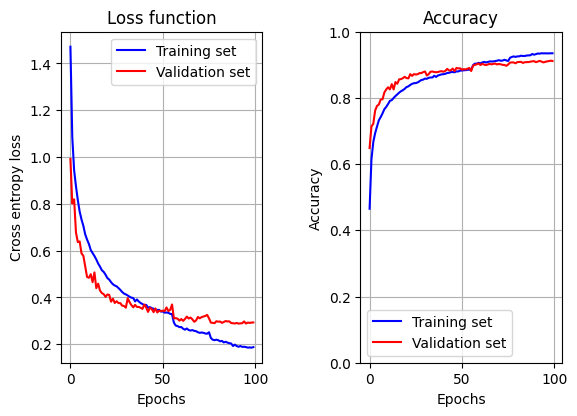

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


# elegimos usar gpu
use_gpu = True
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# creamos una instancia del modelo
basic_cnn_model = G4_CIFAR10_CNN()
# creamos la loss function
loss_fn = nn.CrossEntropyLoss()
# movemos todo lo que haga falta al dispositivo que hayamos elegido
basic_cnn_model = basic_cnn_model.to(device)
loss_fn = loss_fn.to(device)
# inicializamos un valor de learning rate
learning_rate = 0.01
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.SGD(basic_cnn_model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=0.0001)

# determinamos el número de épocas por el que queremos entrenar
n_epochs = 100

# Define batch size
batch_size = 64 # You can adjust this value

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


# Create DataLoaders for batching
train_loader = DataLoader(cifar10_training, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(cifar10_validation, batch_size=batch_size, shuffle=False)

# Con early stopping (patience=10)
model, train_loss, val_loss, train_acc, val_acc = G4_training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=basic_cnn_model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    validation_loader=validation_loader,
    device=device,
    is_fully_connected=False,
    early_stopping_patience=15, # <--- Nuevo parámetro opcional
    scheduler=scheduler
)

# ploteamos los resultados
plot_training_statistics(train_loss, val_loss, train_acc, val_acc)

In [12]:
torch.save(basic_cnn_model.state_dict(), 'best_model_early_stopping_SGD_LRscheduler_+DA.pth') ## Guardar mejor modelo

In [13]:
torch.save({
    'epoch': n_epochs,
    'model_state': basic_cnn_model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
}, 'best_model_early_stopping_SGD_LRscheduler_+DA_checkpoint.pth')

In [14]:
# Encontrar en qué época se obtuvo el mejor validation loss
best_epoch = val_loss.index(min(val_loss)) + 1
best_val_loss = val_loss[best_epoch - 1]
best_val_acc = val_acc[best_epoch - 1]

print(f"\n📊 RESULTADOS DEL MEJOR MODELO:")
print(f"   Época: {best_epoch}")
print(f"   Validation Loss: {best_val_loss:.4f}")
print(f"   Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Training Loss: {train_loss[best_epoch - 1]:.4f}")
print(f"   Training Accuracy: {train_acc[best_epoch - 1]:.4f} ({train_acc[best_epoch - 1]*100:.2f}%)")


📊 RESULTADOS DEL MEJOR MODELO:
   Época: 92
   Validation Loss: 0.2878
   Validation Accuracy: 0.9096 (90.96%)
   Training Loss: 0.1887
   Training Accuracy: 0.9340 (93.40%)
